In [20]:
import sys
import pickle
import os.path as path
import math
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
np.warnings.filterwarnings('ignore')

Change these to True to save the final weights in a .p file to skip training later.

In [21]:
SAVE_OVA = False
SAVE_OVO = False
SAVE_KMEANS = False
SAVE_CONFUSION = False

OUTPUT_FOLDER = "output/"
OVA_FILE = OUTPUT_FOLDER + "ova.p"
OVO_FILE = OUTPUT_FOLDER + "ovo.p"
KMEANS_FILE = OUTPUT_FOLDER + "kmeans-k20-p30.p"

In [22]:
def load_data(filename):
    data = sio.loadmat(filename)
    testX = data["testX"]
    testY = data["testY"]
    trainX = data["trainX"]
    trainY = data["trainY"]
    print("Data loaded. Recieved {} training examples and {} test examples".format(len(trainX), len(testX)))
    return testX, testY, trainX, trainY

In [23]:
def normalize_data(testX, trainX):
    maxVal = np.amax(trainX)
    normalized_testX = testX / maxVal
    normalized_trainX = trainX / maxVal
    return normalized_testX, normalized_trainX

In [24]:
def clean_data(testX, trainX):
    rows_to_remove = []
    # determine which pixels are mostly blank by iterating rows of trainX and removing all rows with less than min_nonzero nonzero entries
    min_nonzero = 600 # threshold for minimum number of images with nonzero values for the pixel
    for i, row in enumerate(trainX.T): # examples in trainX are rows not columns, so to iterate over pixel indeces, we transpose trainX since enumerate returns the rows
        if(np.count_nonzero(row) < min_nonzero):
            rows_to_remove.append(i)
    print("Removed {} rows for having too few nonzero entries".format(len(rows_to_remove)))
    clean_testX = np.delete(testX, rows_to_remove, 1)
    clean_trainX = np.delete(trainX, rows_to_remove, 1)
    return clean_testX, clean_trainX, rows_to_remove

In [25]:
def add_bias(testX, trainX):
    biased_testX = np.concatenate((testX, np.ones((testX.shape[0], 1))), axis=1)
    biased_trainX = np.concatenate((trainX, np.ones((trainX.shape[0], 1))), axis=1)
    return biased_testX, biased_trainX

In [26]:
def evaluate_model(testX, testY, xhat):
    ybar = np.dot(testX, xhat).reshape((1, testY.shape[1]))
    return ybar

In [27]:
def evaluate_confusian(testY, yhat, save=True, filename="confusion"):
    print("Evaluating Confusion matrix")
    confusion = np.zeros((10, 10))
    for i in range(testY.shape[1]):
        confusion[testY[0, i],yhat[0, i]] += 1
    if(save):
        np.savetxt(filename, confusion, fmt="%d", delimiter=",")
    return confusion

In [28]:
def train_one_v_all(trainX, trainY, save=True, filename="ova.p"):
    print("Running one vs all")
    Xhat = np.zeros((trainX.shape[1], 10))
    for digit in range(10):
        print("Getting weights for digit {}".format(digit))
        labels = (np.where(trainY == digit, 1, -1)).T
        xhat = np.linalg.lstsq(trainX, labels)[0]
        Xhat[:,digit] = xhat.reshape(xhat.shape[0])
    ova = {"Xhat": Xhat}
    if(save):
        pickle.dump(ova, open(filename, "wb"))
    return ova

In [29]:
def test_one_v_all(testX, testY, Xhat):
    YBar = np.zeros((10, testY.shape[1]))
    for digit in range(10):
        ybar = evaluate_model(testX, testY, Xhat[:,digit])
        YBar[digit,:] = ybar.reshape(ybar.shape[1])
    yhat = np.argmax(YBar, axis=0).reshape((1, YBar.shape[1]))
    return yhat

In [30]:
def train_one_v_one(trainX, trainY, save=True, filename="ovo.p"):
    print("Running one vs one")
    Xhat = np.zeros((trainX.shape[1], 45))
    Xhat_idx = 0
    for i in range(10):
        for j in range(i + 1, 10):
            print("Getting weights for digit pair ({},{})".format(i, j))
            indeces_to_remove = []
            for idx, y in np.ndenumerate(trainY):
                if(not(y == i or y == j)):
                    indeces_to_remove.append(idx)
            only_ij_X = np.delete(trainX, indeces_to_remove, axis=0)
            only_ij_Y = np.delete(trainY, indeces_to_remove)
            labels = (np.where(only_ij_Y == i, 1, -1)).T
            xhat = np.linalg.lstsq(only_ij_X, labels)[0]
            Xhat[:,Xhat_idx] = xhat.reshape(xhat.shape[0])
            Xhat_idx += 1
    ovo = {"Xhat": Xhat}
    if(save):
        pickle.dump(ovo, open(filename, "wb"))
    return ovo

In [31]:
def test_one_v_one(testX, testY, Xhat):
    YBar = np.zeros((10, testY.shape[1]))
    Xhat_idx = 0
    for i in range(10):
        for j in range(i + 1, 10):
            # print("Evaluating model for digit pair ({},{})".format(i, j))
            ybar = evaluate_model(testX, testY, Xhat[:,Xhat_idx])
            i_row =  np.where(ybar >= 0, YBar[i,:] + 1,  YBar[i])
            j_row =  np.where(ybar < 0, YBar[j,:] + 1,  YBar[j])
            YBar[i,:] = i_row.reshape(i_row.shape[1])
            YBar[j,:] = j_row.reshape(j_row.shape[1])
            Xhat_idx += 1
    yhat = np.argmax(YBar, axis=0).reshape((1, YBar.shape[1]))
    return yhat

In [32]:
def train_kmeans(trainX, K, P, save=True, filename="kmeans.p"):
    min_J_kmeans = None
    max_J_kmeans = None
    J_convergence_limit = 0.005
    for n_pass in range(P):
        C = np.random.randint(K, size=(1, trainX.shape[0]))
        # Init Z for the first time from C
        Z = np.zeros((K, trainX.shape[1]))
        for i in range(K):
            Xi = trainX[C[0,:] == i,:]
            z = (1 / Xi.shape[0]) * np.sum(Xi, axis=0)
            Z[i,:] = z
    
        Jclust = []
        n_iter = 1 
        print("Starting pass {}".format(n_pass))
        while(1):
            print("Starting iteration {}".format(n_iter))
            L2 = np.zeros((trainX.shape[0], K))
            J = 0
            for i in range(K):
                Xi = trainX[C[0,:] == i,:]
                z = (1 / Xi.shape[0]) * np.sum(Xi, axis=0)
                Z[i,:] = z

                L2[:,i] = np.square(np.linalg.norm(trainX - Z[i,:], axis=1))
                Ji = (1 / trainX.shape[0]) * np.sum(np.square(np.linalg.norm(Xi - Z[i,:], axis=1)))
                J += Ji
            Jclust.append(J)
            if(n_iter > 1):
                if(abs(Jclust[-1] - Jclust[-2])/Jclust[-2] < J_convergence_limit):
                    print(("Exiting kmeans loop, convergence reached (J = {})".format(Jclust)))
                    break
            C = np.argmin(L2, axis=1).reshape(1, L2.shape[0])
            n_iter += 1
        kmeans = {"C": C, "Z": Z, "Jclust": Jclust}
        if(max_J_kmeans == None or Jclust[-1] > max_J_kmeans["Jclust"][-1]):
            print("Found new maximum J (or one didn't exist before)")
            max_J_kmeans = kmeans
        if(min_J_kmeans == None or Jclust[-1] < min_J_kmeans["Jclust"][-1]):
            print("Found new minimum J (or one didn't exist before)")
            min_J_kmeans = kmeans
    Kmeans = {"min": min_J_kmeans, "max": max_J_kmeans}
    if(save):
        pickle.dump(Kmeans, open(filename, "wb"))
    return Kmeans

In [33]:
def plot_kmeans(trainX, kmeans, rows_removed):
    colors = ["r", "b", "g", "m"]
    plt.figure()
    for i, kmns in enumerate(kmeans):
        Jclust = kmns["Jclust"]
        plt.plot(Jclust, "{}.-".format(colors[i]))
    print("min and max cost curves:")
    plt.show()

    for _, kmns in enumerate(kmeans):
        Z = kmns["Z"]
        L = Z.shape[1] + len(rows_removed) - 1 # original length of vector is what remains + whats removed - 1 previously added bias term
        # pad z's to make sure vector is 784 long (this alg is junky, but it does the job and speed isn't important at all)
        for i in range(Z.shape[0]):
            axs = plt.subplot(math.ceil(Z.shape[0]/5), 5, i + 1)
            zpad = np.zeros((1, L))
            offset = 0
            for j in range(L):
                if(j in rows_removed):
                    zpad[0, j] = 0
                    offset += 1
                else:
                    if(j - offset == Z.shape[1] - 1): 
                        # If index (j - offset) is the last element of Z (Z.shape[1] = length of teach z including bias term) it is the bias and we want to ignore it
                        offset += 1
                    zpad[0, j] = Z[i,j - offset]
            axs.set_xticks([])
            axs.set_yticks([])
            axs.imshow(zpad.reshape(28, 28), cmap="gray", vmin=0, vmax=1)
        print("representatives:")
        plt.show()

    for _, kmns in enumerate(kmeans):
        Z = kmns["Z"]
        C = kmns["C"]
        L = Z.shape[1] + len(rows_removed) - 1 # original length of vector is what remains + whats removed - 1 previously added bias term

        # pad z's to make sure vector is 784 long (this alg is junky, but it does the job and speed isn't important at all)
        for i in range(Z.shape[0]):
            nearestPoints = np.zeros((10, Z.shape[1]))
            L2 = np.square(np.linalg.norm(trainX - Z[i,:], axis=1))
            for x in range(10):
                min_x_idx = np.argmin(L2)
                min_x = trainX[min_x_idx,:]
                nearestPoints[x,:] = min_x
                L2[min_x_idx] = np.max(L2)
            axs = plt.subplot(11, Z.shape[0], i + 1)
            zpad = np.zeros((1, L))
            nearestPointsPad = np.zeros((10, L))
            offset = 0
            for j in range(L):
                if(j in rows_removed):
                    # Was setting to zero here, but zpad and nearestPointPad are already all 0
                    offset += 1
                else:
                    if(j - offset == Z.shape[1] - 1): 
                        # If index (j - offset) is the last element of Z (Z.shape[1] = length of teach z including bias term) it is the bias and we want to ignore it
                        offset += 1
                    zpad[0, j] = Z[i,j - offset]
                    for x in range(10):
                        nearestPointsPad[x, j] = nearestPoints[x,j - offset]
            axs.set_xticks([])
            axs.set_yticks([])
            axs.imshow(zpad.reshape(28, 28), cmap="gray", vmin=0, vmax=1)
            for x in range(10):
                axs = plt.subplot(11, Z.shape[0], i + 1 + Z.shape[0] * (x + 1))
                axs.set_xticks([])
                axs.set_yticks([])
                axs.imshow(nearestPointsPad[x,:].reshape(28, 28), cmap="gray", vmin=0, vmax=1)
        print("10 closest points to each representative:")
        plt.show()

In [34]:
def cycle_test_data(testX, testY, yhat, offset=0):
    cycle = True
    index = offset
    plt.figure()
    plt.imshow(testX[index,:].reshape(28, 28), cmap="gray", vmin=0, vmax=255)
    print("Predicted: {}, Actual: {}".format(yhat[0, index], testY[0, index]))
    plt.show(block=False)
    while(cycle):
        value = input("Press 'Enter' to show next digit. Press any other key (then 'Enter') to exit.")
        if(value != ""):
            cycle = False
        else:
#             plt.imshow(testX[index,:].reshape(28, 28), cmap="gray", vmin=0, vmax=255)
            print("Predicted: {}, Actual: {}".format(yhat[0, index], testY[0, index]))
            plt.show(block=False)
            index += 1

In [35]:
def print_stats(confusion, alg_name):
    total_correct = 0
    for i in range(10):
        total_correct += confusion[i, i]
    print("Percent Error for {}: {}%".format(alg_name, (1 - total_correct / np.sum(confusion)) * 100))

This just loads and prepares the data. Normalizing (dividing by max) and cleaning (removing pixels which equal 0 in > 99% images) are optional. Feel free to comment those out to see how it affects the output.

In [36]:
testX, testY, trainX, trainY = load_data("mnist")
raw_testX, raw_trainX = testX, trainX
testX, trainX = normalize_data(testX, trainX)
testX, trainX, rows_removed = clean_data(testX, trainX)
testX, trainX = add_bias(testX, trainX)

Data loaded. Recieved 60000 training examples and 10000 test examples
Removed 291 rows for having too few nonzero entries


This will train, test, and optionally save all three models. Feel free to comment one or more of them if you only wish to see one or two.
Note: The kmeans algorithm might take a while with K = 20, P = 30 (find 20 representatives, run process to convergence 30 times). Feel free to lower P if you only want one or a few runs. Also, The kmeans plots will come in pairs of two (besides cost) since we're plotting the results for both the min and the max cost run. The first plot in each set is for the minimum run and the second is for the maximum. Also, the kmeans plotting function is a bit slow because I have to computer the norms of all inputs against all representatives (max 60K * 20 = 1,200,000 norms) so don't worry if plotting it takes several seconds

Evaluating Confusion matrix
Percent Error for One Vs All: 13.929999999999998%
Evaluating Confusion matrix
Percent Error for One Vs One: 7.130000000000003%
min and max cost curves:


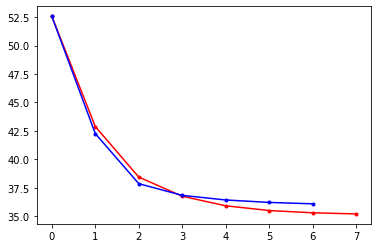

In [ ]:
ova = train_one_v_all(trainX, trainY, SAVE_OVA, OVA_FILE) if not(path.exists(OVA_FILE)) else pickle.load(open(OVA_FILE, "rb"))
Xhat_ova = ova["Xhat"]
yhat_ova = test_one_v_all(testX, testY, Xhat_ova)
confusion_OVA = evaluate_confusian(testY, yhat_ova, save=SAVE_CONFUSION, filename=OUTPUT_FOLDER + "confusion_ova.csv")
print_stats(confusion_OVA, "One Vs All")

ovo = train_one_v_one(trainX, trainY, SAVE_OVO, OVO_FILE) if not(path.exists(OVO_FILE)) else pickle.load(open(OVO_FILE, "rb"))
Xhat_ovo = ovo["Xhat"]
yhat_ovo = test_one_v_one(testX, testY, Xhat_ovo)
confusion_OVO = evaluate_confusian(testY, yhat_ovo, save=SAVE_CONFUSION, filename=OUTPUT_FOLDER + "confusion_ovo.csv")
print_stats(confusion_OVO, "One Vs One")

# cycle_test_data(raw_testX, testY, yhat_ovo, offset=0)
K = 20
P = 30
Kmeans = train_kmeans(trainX, 20, 30, SAVE_KMEANS, KMEANS_FILE) if not(path.exists(KMEANS_FILE)) else pickle.load(open(KMEANS_FILE, "rb"))
min_kmeans = Kmeans["min"]
max_kmeans = Kmeans["max"]
plot_kmeans(trainX, [min_kmeans, max_kmeans], rows_removed)

print("Exiting program successfully")